# Simulations - 1 

In [3]:
library(repr)
options(repr.plot.width=11, repr.plot.height=7, repr.plot.res = 80, repr.plot.quality = 30)
options(jupyter.plot_mimetypes = 'image/png')

setwd("~/yandexDisk/DIPLOMA/CODE/src")
source("simulations.functions.R", echo=FALSE)
source("../../OWL/O_learning_functions.r", echo=FALSE)
debug.file <- ".various.Rdata/Iter.info"
set.seed(0)

Loading SVMW


In [36]:
# Defining control execution constants 
train.data.sample.sizes <- c(50, 100, 200, 400, 800)
test.data.sample.size <- 10000
number.of.covariates = 30
sample.size <- 200
offsets = seq(0.2, 1, length = 10)
control.offset = min(offsets) / 2
lambdas = seq(0,  10,  length=12)

registerDoParallel(cores = 4)
number.of.iters <- 100

offset = 0.1
lambda = 1

In [12]:
GetInitPars <- function(train, q=0.6) {
    index = train$reward > quantile(train$reward, q)
    rqmodel = rq(train$treatment[index] ~ train$covariates[index,] - 1, tau=.5, 
             method="lasso", weights=train$reward[index], lambda = lambda)
    return(coef(rqmodel))
}

# Проблема 2 

In [37]:
global.stat <- numeric()

test <- GetSimulationData(test.data.sample.size)
for (i in seq(1,number.of.iters)) {
    train <- GetSimulationData(sample.size)
    init.pars = GetInitPars(train)
    
    opt.params = list("opt.func"=DCOptimizeWithMML2PenalizedProperIters, "tolerance"=1e-7, "init.pars"=init.pars, "approximation.eps"=1e-7)
    pars.dca.true.MM <- OptimizeParamsOfPolicyFunction(train, offset, PolicyFunLinearKernel, lambda=lambda, opt.hyperparams=opt.params)
    pars.owl <- GetOwlParams(train, lambda, weights = F)
    pars.owl.weights <- GetOwlParams(train, lambda, weights = T)
    pars.owl.dc_loop <- coef(dc_loop(train$covariates[, -1], train$treatment, train$reward, offset, lambda, init.pars[-1], init.pars[1]))
#     opt.params = list("opt.func"=NROptimize, "init.pars"=init.pars, "use.hessian"=TRUE)
#     pars.nr <- OptimizeParamsOfPolicyFunction(train, offset, PolicyFunLinearKernel, lambda=lambda, opt.hyperparams=opt.params)
#     opt.params = list("opt.func"=NROptimize, "init.pars"=init.pars, "use.hessian"=FALSE)
#     pars.nr.without.hess <- OptimizeParamsOfPolicyFunction(train, offset, PolicyFunLinearKernel, lambda=lambda, opt.hyperparams=opt.params)
#     opt.params = list("opt.func"=NROptimize, "init.pars"=init.pars,  "func"=CauchyObjFunc.2max, "func.grad"=CauchyObjFunc.grad.2max, "func.hess"=CauchyObjFunc.hess.2max)
#     pars.cauchy <- OptimizeParamsOfPolicyFunction(train, offset, PolicyFunLinearKernel, lambda=lambda, opt.hyperparams=opt.params)

    opt.decision <- c(1, 0.5, 0.5 , rep(0, length(pars.owl ) - 3))
    data.list <- list("train"=train, "test"=test)
    params.list  <- list("MM.proper.iters"=pars.dca.true.MM, 
                         "OWL.dc_loop"=pars.owl.dc_loop,
#                          "NR" =  pars.nr,
#                          "NR.without.hess" = pars.nr.without.hess, 
                         "Ideal"=opt.decision,
                         "OWL"=pars.owl, 
                         "Init.pars"=pars.owl,
                         "OWL.weights"=pars.owl.weights
                        ) 
    iter.stat <- GetMetricsForParams(params.list, data.list, offset, PolicyFunLinearKernel, lambda)
    global.stat  <- rbind(global.stat, iter.stat)
}

In [38]:
rownames(global.stat) <- NULL

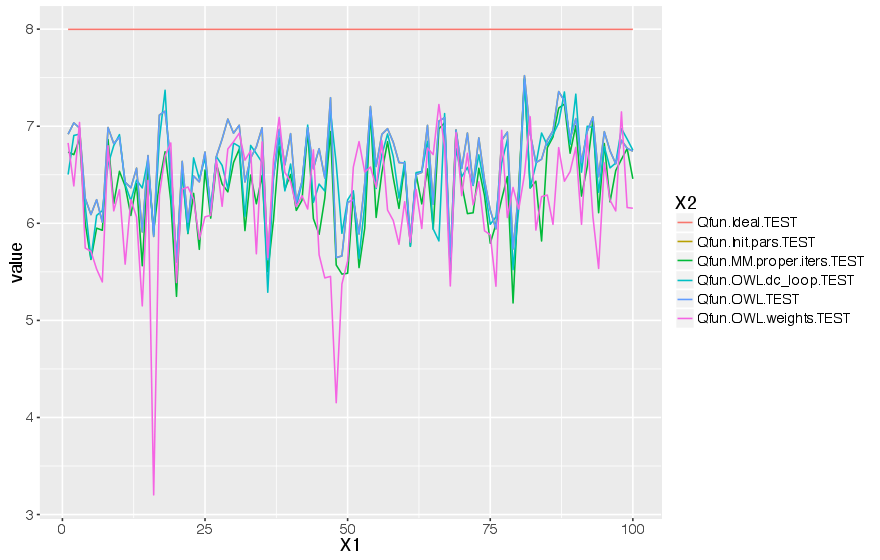

In [39]:
melt = reshape::melt
gl.stat.df <- global.stat
vf.train <- melt(gl.stat.df[, grep("VF.*TRAIN", colnames(gl.stat.df))])
vf.test <- melt(gl.stat.df[, grep("VF.*TEST", colnames(gl.stat.df))])
obj.train <- melt(gl.stat.df[, grep("OBJ.*TRAIN", colnames(gl.stat.df))])
obj.test <- melt(gl.stat.df[, grep("OBJ.*TEST", colnames(gl.stat.df))])
q.train <- melt(gl.stat.df[, grep("Q.*TRAIN", colnames(gl.stat.df))])
q.test <- melt(gl.stat.df[, grep("Q.*TEST", colnames(gl.stat.df))])

# ggplot(q.train , aes(X1, value))  + geom_line(aes(colour = X2)) + theme(text = element_text(size=15))
# ggplot(vf.train, aes(X1, value))  + geom_line(aes(colour = X2)) + theme(text = element_text(size=15))
ggplot(q.test, aes(X1, value))  + geom_line(aes(colour = X2)) + theme(text = element_text(size=15))
# ggplot(vf.test, aes(X1, value))  + geom_line(aes(colour = X2)) + theme(text = element_text(size=15))
# ggplot(obj.train, aes(X1, value))  + geom_line(aes(colour = X2)) + theme(text = element_text(size=15))
# ggplot(obj.test, aes(X1, value))  + geom_line(aes(colour = X2)) + theme(text = element_text(size=15))

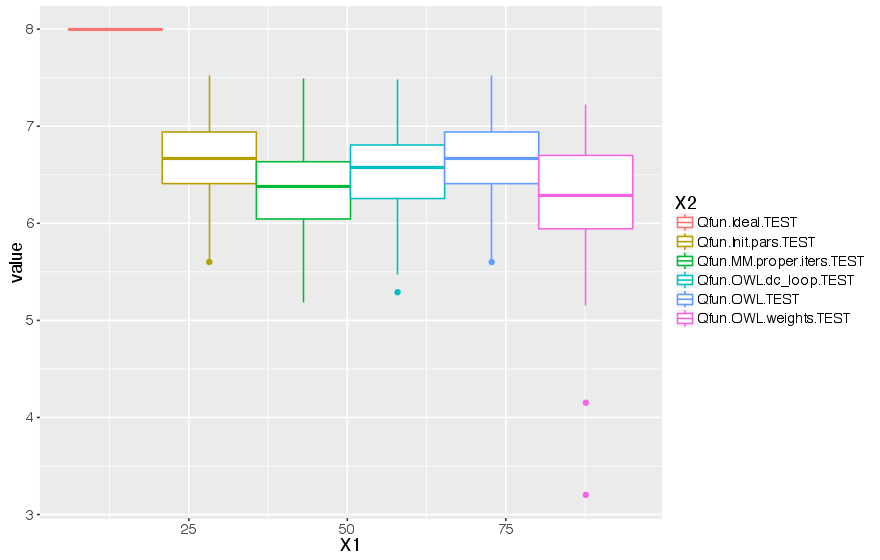

In [40]:
ggplot(q.test, aes(X1, value))  + geom_boxplot(aes(colour = X2)) + theme(text = element_text(size=15))

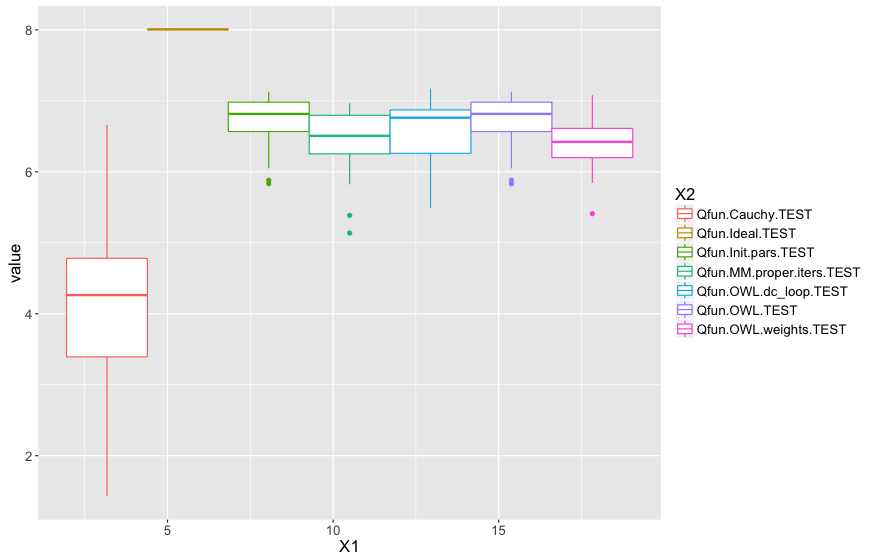

In [18]:
ggplot(q.test, aes(X1, value))  + geom_boxplot(aes(colour = X2)) + theme(text = element_text(size=15))

In [41]:
data.to.plot <-  q.test[q.test$X2 %in% c("Qfun.MM.proper.iters.TEST", "Qfun.OWL.dc_loop.TEST"), ]

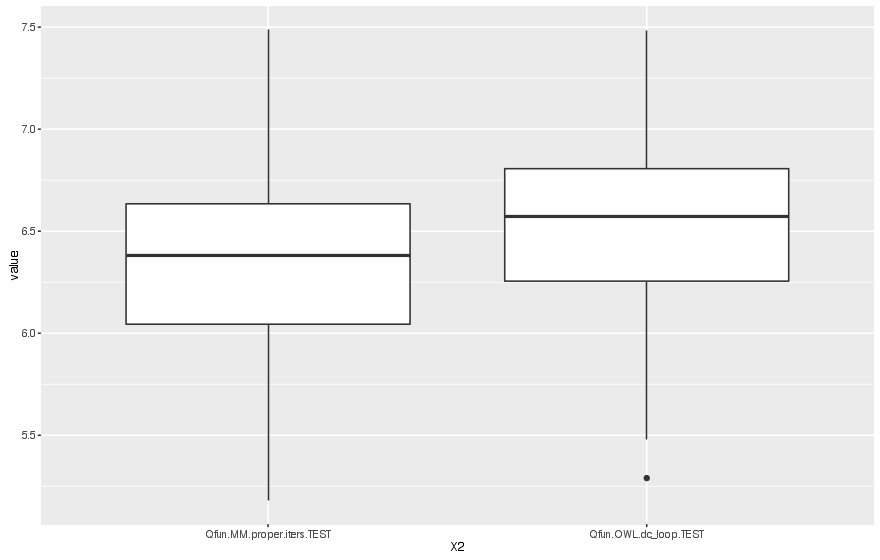

In [42]:
ggplot(data.to.plot, aes(X2, value), labels = c("Hand implemented MM algo", "Out of the box quantile regression")) + 
    geom_boxplot()

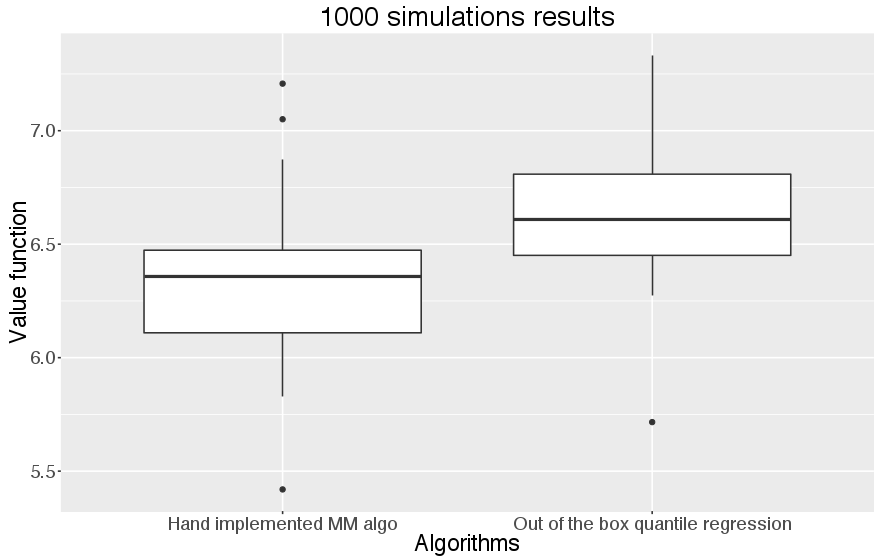

In [35]:
# pdf("~/yandexDisk/DIPLOMA/REPORTS/Presentations/imgs/MMvsRQ.pdf", width = 8, height=6 )
data.to.plot <-  q.test[q.test$X2 %in% c("Qfun.MM.proper.iters.TEST", "Qfun.OWL.dc_loop.TEST"), ]
ggplot(data.to.plot , aes(factor(data.to.plot$X2, labels = c("Hand implemented MM algo", 
                                                             "Out of the box quantile regression")), y=value  )) +  
    geom_boxplot() +  
    theme(text = element_text(size=20)) + 
    xlab("Algorithms") +
    ylab("Value function") +
    ggtitle("1000 simulations results")
# dev.off()

order {base},R Documentation
...,"a sequence of numeric, complex, character or logical vectors, all of the same length, or a classed R object."
x,an atomic vector.
partial,vector of indices for partial sorting. (Non-NULL values are not implemented.)
decreasing,logical. Should the sort order be increasing or decreasing?
na.last,"for controlling the treatment of NAs. If TRUE, missing values in the data are put last; if FALSE, they are put first; if NA, they are removed (see ‘Note’.)"
method,"the method to be used: partial matches are allowed. The default is ""shell"" except for some special cases: see ‘Details’. For details of methods ""shell"" and ""quick"", see the help for sort."


[1]   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17  18
 [19]  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35  36
 [37]  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53  54
 [55]  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71  72
 [73]  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89  90
 [91]  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107 108
[109] 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125 126
[127] 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143 144
[145] 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161 162
[163] 163 164 165 166 167 168 169 170 171 172 173 174 175 176 177 178 179 180
[181] 181 182 183 184 185 186 187 188 189 190 191 192 193 194 195 196 197 198
[199] 199 200

In [49]:
data.to.plot[order(data.to.plot$X2, d), ]

Warning message:
In Ops.factor(data.to.plot$X2): ‘-’ not meaningful for factors

,X1,X2,value
1,1,Qfun.MM.proper.iters.TEST,6.73373916838083
2,2,Qfun.MM.proper.iters.TEST,6.70755885339501
3,3,Qfun.MM.proper.iters.TEST,6.86869649613429
4,4,Qfun.MM.proper.iters.TEST,5.99835326962457
5,5,Qfun.MM.proper.iters.TEST,5.62815994162994
6,6,Qfun.MM.proper.iters.TEST,5.95013432371817
7,7,Qfun.MM.proper.iters.TEST,5.92857437424747
8,8,Qfun.MM.proper.iters.TEST,6.86288694006282
9,9,Qfun.MM.proper.iters.TEST,6.20367915179888
10,10,Qfun.MM.proper.iters.TEST,6.53604077474624


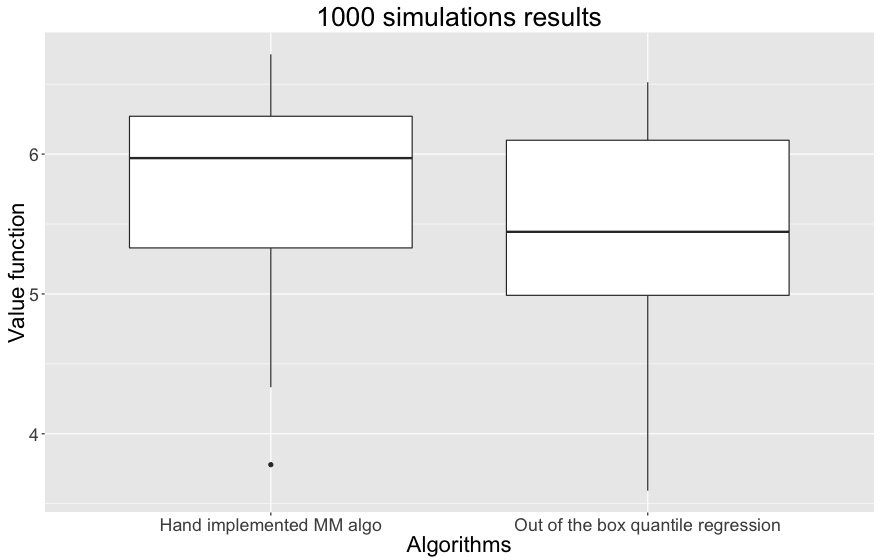

In [44]:
# pdf("~/yandexDisk/DIPLOMA/REPORTS/Presentations/imgs/MMvsRQ.pdf", width = 8, height=6 )
data.to.plot <-  q.test[q.test$X2 %in% c("Qfun.MM.proper.iters.TEST", "Qfun.OWL.dc_loop.TEST"), ]
ggplot(data.to.plot , aes(factor(data.to.plot$X2, labels = c("Hand implemented MM algo", 
                                                             "Out of the box quantile regression")), y=value  )) +  
    geom_boxplot() +  
    theme(text = element_text(size=20)) + 
    xlab("Algorithms") +
    ylab("Value function") +
    ggtitle("1000 simulations results")
# dev.off()

# Проблема 1
#### dc_solution решение зависит от начального приближения

In [51]:
train <- GetSimulationData(sample.size, number.of.covariates)
quants = seq(0.05, 0.99, 0.1)
cs = list()
for (q in quants) {
    init.pars = GetInitPars(train, q=q)
    model = dc_loop(train$covariates[, -1], train$treatment, train$reward, offset, lambda, init.pars[-1], init.pars[1])
    cs[[length(cs) + 1]] <- coef(model)
}
cs <- apply(as.data.frame(cs), 2, unlist)
colnames(cs) <- 1:NCOL(cs)

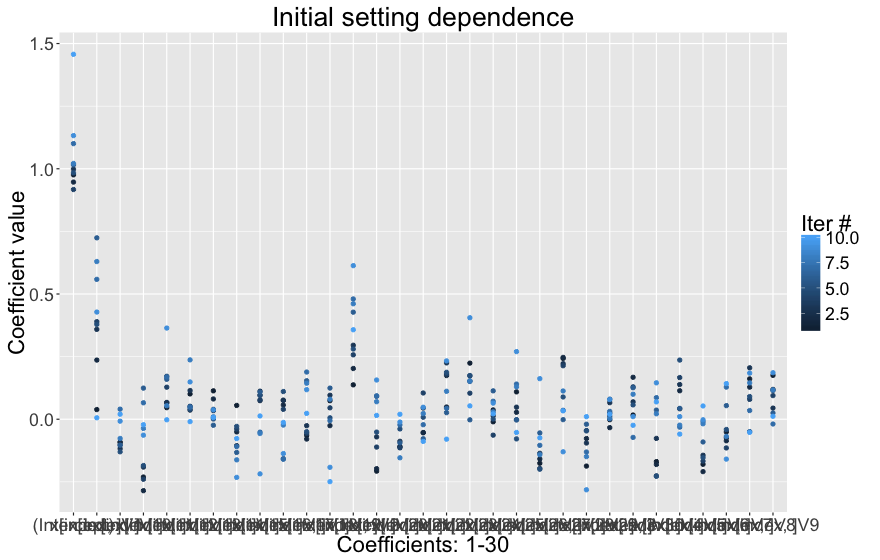

In [5]:
# pdf("~/yandexDisk/DIPLOMA/REPORTS/Presentations/imgs/IniValueDependence.pdf", width = 8, height=6 )
ggplot(melt(cs) , aes(X1, value))  + geom_point(aes(colour = X2)) + theme(text = element_text(size=15)) + 
 theme(text = element_text(size=20)) + 
    xlab("Coefficients: 1-30") +
    ylab("Coefficient value") +
    ggtitle("Initial setting dependence") +
    scale_colour_gradient(name="Iter #")
# dev.off()

In [ ]:
# train <- GetSimulationData(sample.size, number.of.covariates)
quants = seq(0.05, 0.8, 0.1)
cs = list()
for (q in quants) {
  opt.params = list("opt.func"=DCOptimizeWithMML2PenalizedProperIters, "tolerance"=1e-7, "init.pars"=GetInitPars(train, q=q), "approximation.eps"=1e-7)
  cs[[length(cs) + 1]] <- OptimizeParamsOfPolicyFunction(train, offset, PolicyFunLinearKernel, lambda=lambda, opt.hyperparams=opt.params)
}
cs <- apply(as.data.frame(cs), 2, unlist)
colnames(cs) <- as.factor(1:NCOL(cs))
mcs  <-  melt(cs)
names(mcs) <- c("Coef.num", "Iteration", "Value")

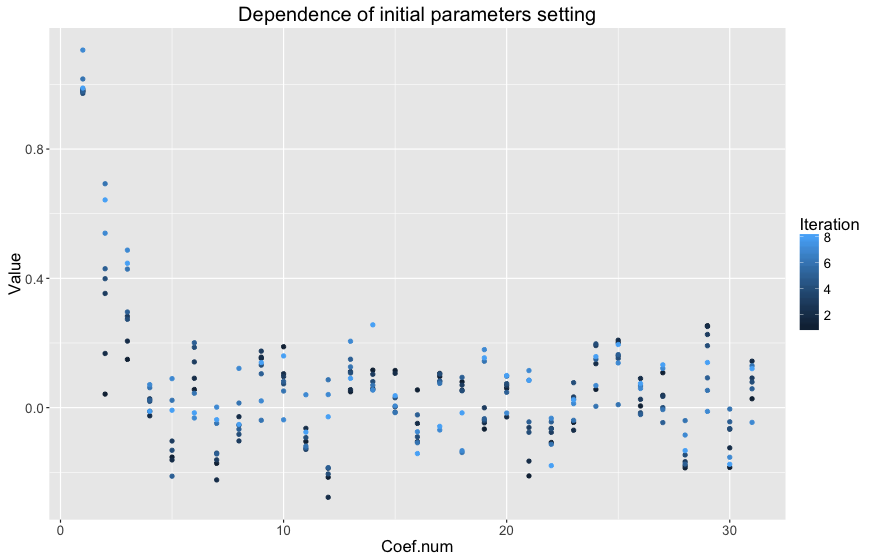

In [25]:
ggplot(mcs, aes(x=Coef.num,  y=Value))  + 
  geom_point(aes(colour = Iteration)) + 
  theme(text = element_text(size=15)) + 
  labs(title="Dependence of initial parameters setting")

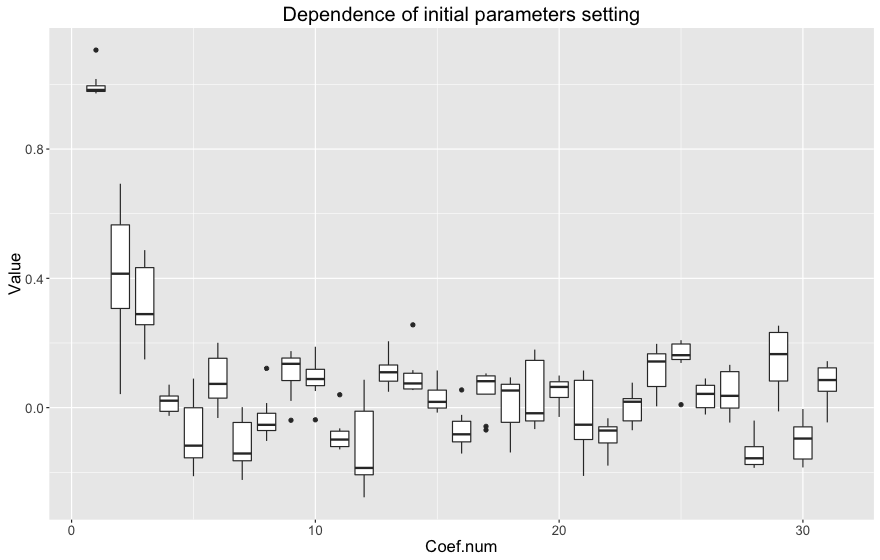

In [38]:
ggplot(mcs, aes(x=Coef.num,  y=Value))  + 
  geom_boxplot(aes(group=Coef.num)) + 
  theme(text = element_text(size=15))  + 
  labs(title="Dependence of initial parameters setting")

# Big troubles with rq: ACHTUNG !!!!!!!

Quantile regression, который используется в статье **вообще** 
- не использует информацию  о tau !!! 
- А судя по коду, еще и совершенно не учитываются веса!!! 

In [346]:
cfss = coef(rq(data$treatment ~ data$covariates - 1, tau = c(seq(0.1, 0.9, 0.1)), weights = data$reward))
head(cfss)

,tau= 0.1,tau= 0.2,tau= 0.3,tau= 0.4,tau= 0.5,tau= 0.6,tau= 0.7,tau= 0.8,tau= 0.9
data$covariates(Intercept),0.2695592,0.4612590,0.6460704,0.7969178,0.9600419,1.1686011,1.3486666,1.5337747,1.7429178
data$covariatesV1,0.08499347,0.10156280,0.15021472,0.13075530,0.12014702,0.17530754,0.12401650,0.09247840,0.07716772
data$covariatesV2,0.09877492,0.11494354,0.17747629,0.18601151,0.17899222,0.16163674,0.18362326,0.10437682,0.06693181
data$covariatesV3,0.041876518,0.031078754,0.001627871,-0.013349092,-0.031325690,-0.045655573,-0.019190527,-0.047201243,-0.022031111
data$covariatesV4,0.0042798079,-0.0049553903,0.0006184262,-0.0070040480,0.0295984392,-0.0174543135,-0.0301126986,-0.0625922833,-0.0420370406
data$covariatesV5,-0.0145095903,-0.0041969487,0.0054357252,-0.0009545133,0.0325679396,0.0545564748,-0.0089700849,-0.0177899977,0.0052986276


In [369]:
cfss_lasso = coef(rq(data$treatment ~ data$covariates - 1, tau = c(seq(0.1, 0.9, 0.1)), method = "lasso", weights = data$reward, lambda = lambda))
head(cfss_lasso)

[1] "assuming many taus!"
[1] "weighted!"
[1] "weighted!"
[1] "weighted!"
[1] "weighted!"
[1] "weighted!"
[1] "weighted!"
[1] "weighted!"
[1] "weighted!"
[1] "weighted!"


,tau= 0.1,tau= 0.2,tau= 0.3,tau= 0.4,tau= 0.5,tau= 0.6,tau= 0.7,tau= 0.8,tau= 0.9
data$covariates(Intercept),0.2695592,0.4612590,0.6460704,0.7969178,0.9600419,1.1686011,1.3486666,1.5337747,1.7429178
data$covariatesV1,0.08499347,0.10156280,0.15021472,0.13075530,0.12014702,0.17530754,0.12401651,0.09247840,0.07716772
data$covariatesV2,0.09877492,0.11494354,0.17747629,0.18601151,0.17899222,0.16163674,0.18362326,0.10437682,0.06693181
data$covariatesV3,0.041876518,0.031078754,0.001627871,-0.013349092,-0.031325690,-0.045655573,-0.019190526,-0.047201243,-0.022031111
data$covariatesV4,0.0042798078,-0.0049553903,0.0006184262,-0.0070040480,0.0295984392,-0.0174543135,-0.0301126980,-0.0625922832,-0.0420370406
data$covariatesV5,-0.0145095903,-0.0041969487,0.0054357252,-0.0009545133,0.0325679396,0.0545564748,-0.0089700856,-0.0177899977,0.0052986276


In [260]:
cfss_lasso_another_weights = coef(rq(data$treatment ~ data$covariates - 1, tau = c(seq(0.1, 0.9, 0.1)),  weights = sort(data$reward), lambda = lambda, method="lasso"))
head(cfss_lasso_another_weights)

,tau= 0.1,tau= 0.2,tau= 0.3,tau= 0.4,tau= 0.5,tau= 0.6,tau= 0.7,tau= 0.8,tau= 0.9
data$covariates(Intercept),0.990421,0.990421,0.990421,0.990421,0.990421,0.990421,0.990421,0.990421,0.990421
data$covariatesV1,0.01182788,0.01182788,0.01182788,0.01182788,0.01182788,0.01182788,0.01182788,0.01182788,0.01182788
data$covariatesV2,0.02340279,0.02340279,0.02340279,0.02340279,0.02340279,0.02340279,0.02340279,0.02340279,0.02340279
data$covariatesV3,-0.01109298,-0.01109298,-0.01109298,-0.01109298,-0.01109298,-0.01109298,-0.01109298,-0.01109298,-0.01109298
data$covariatesV4,0.01856877,0.01856877,0.01856877,0.01856877,0.01856877,0.01856877,0.01856877,0.01856877,0.01856877
data$covariatesV5,0.03131871,0.03131871,0.03131871,0.03131871,0.03131871,0.03131871,0.03131871,0.03131871,0.03131871


### Influence of initial tau (without weights) on initial parameters

Обычный подход к начальному приближению (он же -- результат симуляции) это квантильная медианная регрессия на 40% лучших данных (отнсоительно reward). При этом, как было установлено ранее, эта регрессия не учитывала веса и tau. Попробуем:
    - сравнить начальные веса, как результат квантильной регресси с весами и без весов
    - по результатам предыдущего пункта поиграться с параметром tau

#### 1. Initial params with regularization versus params trained with weights and without regularization

In [448]:
GetOwlParamsWithoutWeights <- function (data, lambda, q = 0.6, t = 0.5) {
    constant = min(quantile(data$raw.reward, q), 0)
    data$weight = data$raw.reward - constant
    index = which(data$raw.reward > quantile(data$raw.reward, q))
    rqmodel = rq(data$treatment[index] ~ data$covariates[index,] - 1, tau = t, method = "lasso", lambda = lambda)
    coefs = coef(rqmodel)
    return(matrix(coefs))
}

In [446]:
GetOwlParamsWithWeightsAndTau <- function (data, q = 0.6, t = 0.5) {
    constant = min(quantile(data$raw.reward, q), 0)
    data$weight = data$raw.reward - constant
    index = which(data$raw.reward > quantile(data$raw.reward, q))
    rqmodel = rq(data$treatment[index] ~ data$covariates[index,] - 1, tau = t, weights = data$weight[index])
    coefs = coef(rqmodel)
    return(matrix(coefs))
}

In [450]:
train <- GetSimulationData(sample.size, number.of.covariates)
test <- GetSimulationData(test.data.sample.size, number.of.covariates)
data.list <- list("train"=train, "test"=test)

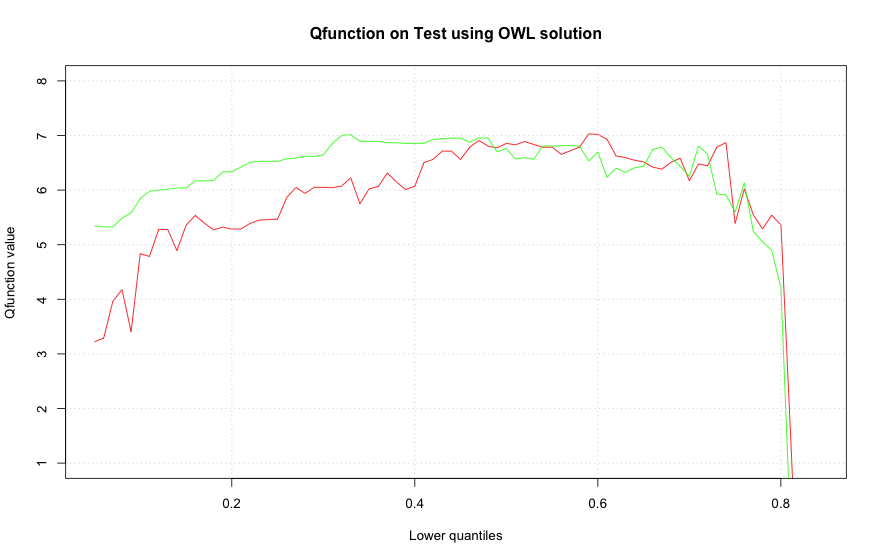

In [451]:
quants = seq(0.05, 0.84, 0.01)
taus = seq(0.05, 0.95, 0.01)
stat = list()
q = 0.6
t = 0.5
for (q in quants) {
# for (t in taus) {
    pars.owl.no.weights <- GetOwlParamsWithoutWeights(train, lambda, q = q, t)  
    pars.owl.weights <- GetOwlParamsWithWeightsAndTau(train, q = q, t)  
    params.list <- list("OWL.reg"=pars.owl.no.weights, "OWL.weights"=pars.owl.weights)
    s = GetMetricsForParams(params.list, data.list, offset, PolicyFunLinearKernel, lambda)
#     s <- cbind(s, pars=params.list)
    stat = rbind(stat, s) 
}
st = data.frame(quantile=quants,  stat)
plot(quants,  unlist(st[, "Qfun.OWL.reg.TEST"]), type="l", ylim=c(1,8), col="red", xlab="", ylab="")
lines(quants, unlist(st[, "Qfun.OWL.weights.TEST"]), type="l", ylim=c(1,8), col="green", xlab="", ylab="")
title("Qfunction on Test using OWL solution", xlab = "Lower quantiles", ylab="Qfunction value")
grid()

#### 2. Initial params with regularization versus params trained with weights and without regularization

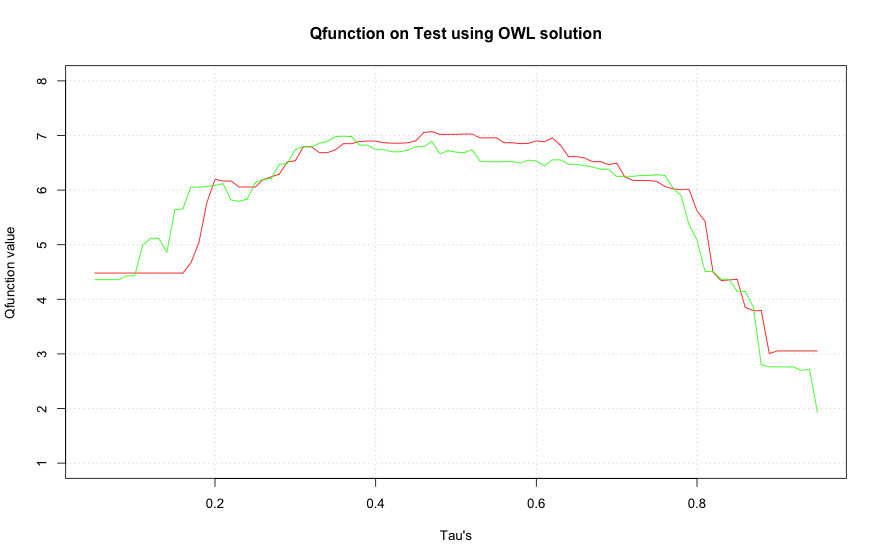

In [452]:
quants = seq(0.05, 0.85, 0.01)
taus = seq(0.05, 0.95, 0.01)
stat = list()
q = 0.6
t = 0.5
# for (q in quants) {
for (t in taus) {
    pars.owl.reg <- GetOwlParamsWithoutWeights(train, lambda, q = q, t)  
    pars.owl.weights <- GetOwlParamsWithWeightsAndTau(train, q = q, t)  
    params.list <- list("OWL.reg"=pars.owl.reg, "OWL.weights"=pars.owl.weights)
    s = GetMetricsForParams(params.list, data.list, offset, PolicyFunLinearKernel, lambda)
#     s <- cbind(s, pars=params.list)
    stat = rbind(stat, s) 
}
st = data.frame(taus=taus,  stat)
plot(taus,  unlist(st[, "Qfun.OWL.reg.TEST"]), type="l", ylim=c(1,8), col="red", xlab="", ylab="")
lines(taus, unlist(st[, "Qfun.OWL.weights.TEST"]), type="l", ylim=c(1,8), col="green", xlab="", ylab="")
title("Qfunction on Test using OWL solution", xlab = "Tau's", ylab="Qfunction value")
grid()

# Why simple quantile regression is the best out of all possible models ? 

In [45]:
train <- GetSimulationData(sample.size, number.of.covariates)
test <- GetSimulationData(test.data.sample.size, number.of.covariates)
data.list <- list("train"=train, "test"=test)
pars.owl <- GetOwlParams(train, lambda, q = 0.6, 0.5) 

In [48]:
q = 0.6
t = 0.5
data = train
constant = min(quantile(data$raw.reward, q), 0)
data$weight = data$raw.reward - constant
index = which(data$raw.reward > quantile(data$raw.reward, q))
rqmodel = rq(data$treatment[index] ~ data$covariates[index, ] - 1, tau = t, method = "lasso", weights = data$weight[index],  lambda = lambda)
coefs = coef(rqmodel)

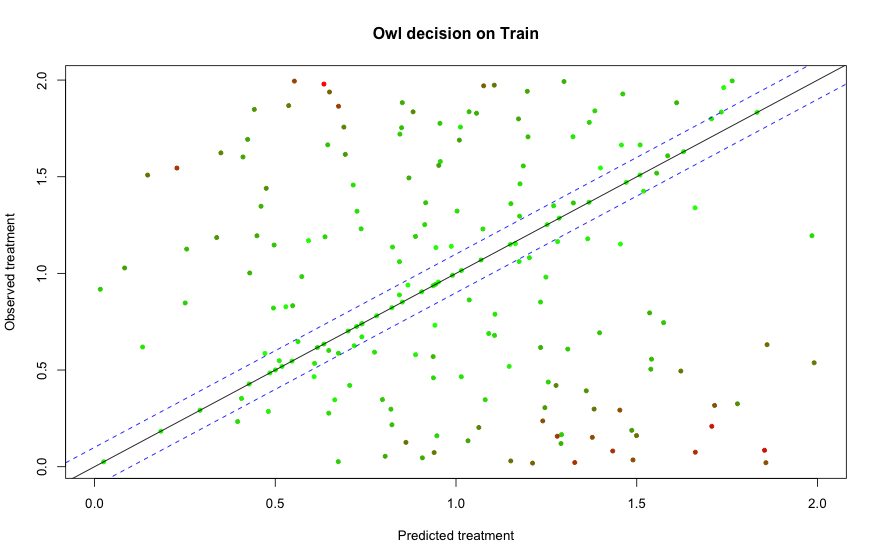

In [49]:
PlotDecsionsVersusObserved(train, PolicyFunLinearKernel, coefs, offset = offset, title = "Owl decision on Train")

In [153]:
quants = seq(0.05, 0.99, 0.01)
taus = seq(0.05, 0.99, 0.01)
stat = list()
q = 0.6
# for (q in quants) {
for (tau in taus) {
     
    s = GetMetricsForParams(list("OWL"=pars.owl), data.list, offset, PolicyFunLinearKernel, lambda)
#     PlotDecsionsVersusObserved(test, PolicyFunLinearKernel, pars.owl, offset = offset, title = "Owl decision on TEST")
    s <- cbind(s, pars=list(pars.owl))
    stat = rbind(stat, s) 
}
st = data.frame(quantile=quants,  stat)

# Vizualizations

In [135]:
# tmp.dir = "/tmp/pngslides/"
# system(paste("mkdir -p ", tmp.dir))
# system(paste("rm -vf ", tmp.dir, "*", sep=""))

# counter = 1
# f <- function(row) {
#     png(paste(tmp.dir, sprintf("%03d", counter), ".png", sep = ""),
#         width = 1000, height = 900, units = "px", pointsize = 17, res=100)
#     PlotDecsionsVersusObserved(test, PolicyFunLinearKernel, as.matrix(unlist(row["pars"])), 
#                                offset=offset, title = paste("Quantile #", row["quantile"]))
#     dev.off()
#     counter <<- counter + 1
# }
# apply(st, 1, f)

# src = paste(tmp.dir, "*.png", sep="")
# dst = paste(tmp.dir, "process.gif", sep="")
# system(paste("convert -delay 20", src, dst))